In [1]:
import numpy as np
import cv2

In [2]:
def obtain_dataset(folder):
    """Loads images and stores them in 4d numpy arrays (batch first) as RGB values and reads labels, returns the tuple X,y"""
    import glob
    import numpy as np
    import cv2
    
    num_samples = sum(1 for _ in glob.iglob(folder + '/**/*.png', recursive=True))
    
    X = np.zeros([num_samples,128,128,3],'uint8')
    y = np.empty([num_samples],'object_')
    i=0
        
    for file in glob.iglob(folder + '/**/*.png', recursive=True):
        im = cv2.imread(file)
        
        filename = file.split("/")
        
        if '\\' in file:
            filename = file.split("\\")

        y[i] = filename[1]
        X[i,:,:,:] = im
        
        i+=1
    return X,y

In [3]:
def obtain_dataset_hog(folder,augment=False):
    """reads image dataset, returning HoG features and labels"""
    import glob
    import numpy as np
    import cv2
    # assuming 128x128 size images and HoGDescriptor length of 34020
    hog_feature_len=34020
    hog = cv2.HOGDescriptor()
    #code for obtaining hog feature for one image file name

    # use this to read all images in the three directories and obtain the set of features X and train labels Y
    # you can assume there are three different classes in the image dataset
    
    #assuming 150 images
    
    inc = 1
        
    X = np.zeros([150*inc,hog_feature_len])
    y = np.zeros(150*inc)
    
    i=0
     
    for file in glob.iglob(folder + '/**/*.png', recursive=True):
        img = cv2.imread(file)
        #norm_im = np.zeros((128,128))
        #normalise image
        #img = cv2.normalize(im,  norm_im, 0, 255, cv2.NORM_MINMAX)
    
        #regular image
        X[i,:] = hog.compute(img).reshape(1,-1)

        
        filename = file.split('\\')
        for ii in range(inc):
            if 'bikes' in filename:
                y[i+ii] = 0
            elif 'cars' in filename:
                y[i+ii] = 1
            elif 'people' in filename:
                y[i+ii] = 2
                
        i+=inc
    return (X,y.astype(int)) 

In [76]:
#feature extraction methods

def meanpixel(X):
    X_new = np.empty([X.shape[0],X.shape[1]*X.shape[2]])
    for  i,img in enumerate(X):
        X_new[i] = img.mean(axis=2).reshape(1,-1)
    return X_new

def greyscale(X):
    X_new = np.empty([X.shape[0],X.shape[1]*X.shape[2]])
    for  i,img in enumerate(X):
        X_new[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(1,-1)
    return X_new

def allpixels(X):
    X_new = np.empty([X.shape[0],X.shape[1]*X.shape[2]*X.shape[3]])
    for  i,img in enumerate(X):
        X_new[i] = img.reshape(1,-1)
    return X_new

def HoG(X):
    hog_feature_len=34020
    hog = cv2.HOGDescriptor()
    X_new = np.empty([X.shape[0],hog_feature_len])
    for  i,img in enumerate(X):
        X_new[i] = hog.compute(img).reshape(1,-1)
    return X_new

In [68]:
x_vis_reg = X_raw[1]
gray = cv2.cvtColor(x_vis_reg, cv2.COLOR_BGR2GRAY)

In [383]:
import cv2
cv2.imshow('i',x_vis_reg)
cv2.waitKey(0)
cv2.imshow('ii',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Classifiers

In [ ]:
class BoostingClassifier(BaseEstimator, ClassifierMixin):#):
     
    def __init__(self,num_trees=500,tree_depth=2,features='HoG',flip=True,noise=False):
        
        self.num_trees=num_trees
        self.tree_depth=tree_depth
        self.features = features
        self.flip=flip
        self.noise= noise
        
    def fit(self, X, y):
        import numpy as np
        from sklearn.base import clone
        from sklearn.tree import DecisionTreeClassifier
        
        
        self.classes_ = np.unique(y)
        
        # image processing
        if len(X.shape) == 4:
            X,y = augment_training_img(X,y,flip=self.flip,noise=self.noise)
        
            # feature extraction
            if self.features == 'meanpixel':
                X = meanpixel(X)
            elif self.features == 'HoG':
                X = HoG(X)
            elif self.features == 'allpixels':
                X = allpixels(X)
        
        self.X_ = X
        self.y_ = y
        
        self.base_estimator_ = DecisionTreeClassifier(max_depth=self.tree_depth)
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        M = self.num_trees
        
        estimator_weights = np.zeros(M)
        estimator_errors = np.zeros(M)
        classifiers = []
        
        #initialise weights
        sample_weights = np.ones(n_samples) / n_samples       
        
        #loop for num_trees times
        for m in range(M):
            
            # fit classifier to data using weights
            estimator = clone(self.base_estimator_)
            estimator.fit(X,y,sample_weight=sample_weights)
            classifiers.append(estimator)

            # compute the error of model m
            error = sample_weights[estimator.predict(X) != y].sum()
            estimator_errors[m] = error
            
            # compute the weight term 
            model_weight = np.log((1-error)/error) + np.log(len(self.classes_)-1)
            estimator_weights[m] = model_weight
            
            # set new weights
            f = np.ones(n_samples)
            f[estimator.predict(X) != y] *= np.exp(model_weight)
            sample_weights *= f
            
            # renormalise weights
            sample_weights /= sample_weights.sum()
        
        self.estimator_weights_ = estimator_weights
        self.estimator_errors_ = estimator_errors
        self.classifiers_ = classifiers
        
        # Return the classifier
        return self
    
    def predict(self, X):
        
        
        # image processing
        if self.features == 'meanpixel':
            X = meanpixel(X)
        elif self.features == 'HoG':
            X = HoG(X)
        elif self.features == 'allpixels':
            X = allpixels(X)
        
        pred_array = np.zeros([X.shape[0],len(self.classes_)])
        pred_temp = np.zeros([X.shape[0],len(self.classes_)])
        
        for m in range(self.num_trees):
            pred = self.classifiers_[m].predict(X)
            for i in range(len(self.classes_)):
                pred_temp[:,i] = (pred == self.classes_[i])
            pred_array += pred_temp * self.estimator_weights_[m]
        
        pred_vals = np.argmax(pred_array, axis = 1)
        
        prediction = np.array([self.classes_[p] for p in pred_vals])
            
        return prediction
    
    def score(self,X,y):
        prediction = self.predict(X)
        score = sum(prediction==y) / len(y)
        return score

In [ ]:
class SVMClassifier_hp(BaseEstimator, ClassifierMixin):
    def __init__(self,C=5,kernel='hist_int',gamma=70,poly_degree=3,features='HoG'):
        #implement initialisation
        self.C=C
        self.kernel = kernel
        self.gamma = gamma
        self.poly_degree = poly_degree
        self.features=features

        
    def fit(self, X, y):
        from sklearn.svm import SVC
        from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, chi2_kernel
        import numpy as np
        
        self.classes_ = unique_labels(y)
        
        # image augmentation
        X,y = augment_training_img(X,y,flip=True)
        
        # feature extraction
        if self.features == 'meanpixel':
            X = meanpixel(X)
        elif self.features == 'HoG':
            X = HoG(X)
        elif self.features == 'allpixels':
            X = allpixels(X)
        
        if self.kernel == 'linear':
            self.kernel_train_ = linear_kernel(X)
        elif self.kernel == 'rbf':
            self.kernel_train_ = rbf_kernel(X,gamma=self.gamma)
        elif self.kernel == 'poly':
            self.kernel_train_ = polynomial_kernel(X,degree=self.poly_degree,gamma=self.gamma,coef0=0)
        elif self.kernel == 'sigmoid':
            self.kernel_train_= sigmoid_kernel(X,gamma=self.gamma,coef0=0)
        elif self.kernel == 'chi2':
            self.kernel_train_= chi2_kernel(X,gamma=self.gamma)
        elif self.kernel == 'hist_int':
            self.kernel_train_= self.hist_kernel(X,X)
        elif self.kernel == 'log':
            self.kernel_train_ = self.log_kernel(X,X,self.poly_degree)
        elif self.kernel == 'cauchy':
            self.kernel_train_ = self.cauchy_kernel(X,X,self.gamma)
        elif self.kernel == 't_student':
            self.kernel_train_ = self.t_student_kernel(X,X,self.poly_degree)
        
        self.X_ = X
        self.y_ = y
        
        fitted_model = SVC(kernel="precomputed", C=self.C).fit(self.kernel_train_,self.y_)
        
        self.fitted_model = fitted_model
        
        return self
    
    def predict(self,X):
        from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, chi2_kernel
        import numpy as np
        
        num_samples = len(X)
        
        # image processing

        if self.features == 'meanpixel':
            X = meanpixel(X)
        elif self.features == 'HoG':
            X = HoG(X)
        elif self.features == 'allpixels':
            X = allpixels(X)

        if self.kernel == 'linear':
            kernel_test = linear_kernel(X,self.X_)
        elif self.kernel == 'rbf':
            kernel_test = rbf_kernel(X,self.X_,gamma=self.gamma)
        elif self.kernel == 'poly':
            kernel_test = polynomial_kernel(X,self.X_,degree=self.poly_degree,gamma=self.gamma,coef0=0)
        elif self.kernel == 'sigmoid':
            kernel_test = sigmoid_kernel(X,self.X_,gamma=self.gamma,coef0=0)
        elif self.kernel == 'chi2':
            kernel_test = chi2_kernel(X,self.X_,gamma=self.gamma)
        elif self.kernel == 'hist_int':
            kernel_test = self.hist_kernel(X,self.X_)
        elif self.kernel == 'log':
            kernel_test = self.log_kernel(X,self.X_,self.poly_degree)
        elif self.kernel == 'cauchy':
            kernel_test = self.cauchy_kernel(X,self.X_,self.gamma)
        elif self.kernel == 't_student':
            kernel_test = self.t_student_kernel(X,self.X_,self.poly_degree)
        
        r = self.fitted_model.predict(kernel_test)
            
        return r
    
    def hist_kernel(self,x,y):
        # a histogram intersection kernel
        kernel = np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                kernel[i, j] = np.minimum(x[i,:],y[j,:]).sum()
        return kernel
    
    def log_kernel(self,x,y,d):
        import numpy as np
        kernel = np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                dist = np.linalg.norm(x[i,:]-y[j,:])
                kernel[i, j] = - np.log(dist**d + 1)
        return kernel
    
    def cauchy_kernel(self,x,y,s):
        import numpy as np
        kernel = np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                dist = np.linalg.norm(x[i,:]-y[j,:])
                den = 1 + (dist**2 / s**2)
                kernel[i, j] = 1 / den
        return kernel
    
    def t_student_kernel(self,x,y,d):
        import numpy as np
        kernel = np.zeros([x.shape[0],y.shape[0]])
        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                dist = np.linalg.norm(x[i,:]-y[j,:])**d
                kernel[i, j] = 1 / (1 + dist)
        return kernel
    
    def score(self,X,y):
        prediction = self.predict(X)
        score = sum(prediction==y) / len(y)
        return score

# Feature representations

In [61]:
X_hog,_ = obtain_dataset_hog("image_dataset")
X_raw,y = obtain_dataset("image_dataset")
X_mean = meanpixel(X_raw)
X_gray = greyscale(X_raw)
X_all = allpixels(X_raw)

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC(kernel='linear',C=5)

In [86]:
svself = SVMClassifier(pca=True,kernel='linear')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svc,x,y).mean()}")

CV = 0.45999999999999996
CV = 0.48666666666666664
CV = 0.5
CV = 0.4333333333333333


In [87]:
svself = SVMClassifier(pca=True,kernel='hist_int')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svc,x,y).mean()}")

CV = 0.45999999999999996
CV = 0.48666666666666664
CV = 0.5
CV = 0.4333333333333333


In [84]:
svself = SVMClassifier(pca=True,kernel='linear')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svself,x,y).mean()}")

CV = 0.45999999999999996
CV = 0.48666666666666664
CV = 0.5
CV = 0.4333333333333333


In [85]:
svself = SVMClassifier(pca=True,kernel='hist_int')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svself,x,y).mean()}")

CV = 0.42666666666666664
CV = 0.4733333333333333
CV = 0.48
CV = 0.42666666666666664


In [92]:
svself = SVMClassifier(standardise=True,kernel='linear')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svself,x,y).mean()}")

CV = 0.4666666666666666
CV = 0.48
CV = 0.47999999999999987
CV = 0.42666666666666664


In [93]:
svself = SVMClassifier(standardise=True,kernel='hist_int')
for x in [X_hog, X_mean, X_gray, X_all]:
    print(f"CV = {cross_val_score(svself,x,y).mean()}")

CV = 0.4666666666666666
CV = 0.5333333333333334
CV = 0.5266666666666667
CV = 0.54


# Preprocessing

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
def sp_noise(image):
    #adds 5% salt&pepper noise
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.01
    out = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * row*col * s_vs_p)
    coords = [[np.random.randint(row),np.random.randint(col)] for i in range(int(num_salt))]
    for coord in coords:
        out[coord[0],coord[1],:] = 255

    # Pepper mode
    num_pepper = np.ceil(amount * row*col * s_vs_p)
    coords = [[np.random.randint(row),np.random.randint(col)] for i in range(int(num_pepper))]
    for coord in coords:
        out[coord[0],coord[1],:] = 0
    return out

In [119]:
X_aug, y_aug = augment_training_img(X_raw,y,flip=True,rotate=True,shift=True,norm=True,noise=True)

In [120]:
cv2.imwrite('Figures\\Images\\regular.jpg', X_aug[5]) 
cv2.imwrite('Figures\\Images\\flip.jpg', X_aug[6])
cv2.imwrite('Figures\\Images\\rotate.jpg', X_aug[7]) 
cv2.imwrite('Figures\\Images\\shift.jpg', X_aug[8]) 
cv2.imwrite('Figures\\Images\\noise.jpg', X_aug[9]) 

True

In [116]:
cv2.imshow('i',X_aug[5])
cv2.waitKey(0)
cv2.imshow('i',X_aug[6])
cv2.waitKey(0)
cv2.imshow('i',X_aug[7])
cv2.waitKey(0)
cv2.imshow('i',X_aug[8])
cv2.waitKey(0)
cv2.imshow('i',X_aug[9])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [118]:
def augment_training_img(X,y,flip=False,rotate=False,shift=False,norm=False,noise=False):
    import numpy as np
    import cv2
    import random
    
    inc = 1  ####
    
    if flip:
        inc+=1
    if rotate:
        inc+=1
    if shift:
        inc+=1
    if noise:
        inc+=1
    
    #hog_feature_len=34020
    #hog = cv2.HOGDescriptor()
    X_new = np.zeros([len(X)*inc,128,128,3])
    y_new = np.empty([len(y)*inc],'object_')
    
    i=0
    c=1
    
    for image in X:
        
        if norm:
            #normalise image
            norm_im = np.zeros((128,128))
            image = cv2.normalize(image,  norm_im, 0, 255, cv2.NORM_MINMAX)
        
        #1. regular image
        #X_new[i] = hog.compute(image).reshape(1,-1)
        X_new[i] = image
        y_new[i] = y[i//inc]
        
        if flip:
            #2. horizontal flip
            imfliph = cv2.flip(image, 1)
            #X_new[i+c,:] = hog.compute(imfliph).reshape(1,-1)
            X_new[i+c,:] = imfliph
            y_new[i+c] = y[i//inc]
            c+=1
        
        if rotate:
            #3. rotation
            
            angle = 15
            M = cv2.getRotationMatrix2D((int(128/2), int(128/2)), angle, 1)
            img_rot = cv2.warpAffine(image, M, (128, 128))
            #X_new[i+c,:] = hog.compute(img_rot).reshape(1,-1)
            X_new[i+c,:] = img_rot
            y_new[i+c] = y[i//inc]
            c+=1
        
        if shift:
            #4. horizontal shift
            ratio = 0.2
            h, w = image.shape[:2]
            to_shift = w*ratio
            if ratio > 0:
                ishift = image[:, :int(w-to_shift), :]
            if ratio < 0:
                ishift = image[:, int(-1*to_shift):, :]
            img_shift = cv2.resize(ishift, (h, w), cv2.INTER_CUBIC)
            #X_new[i+c,:] = hog.compute(img_shift).reshape(1,-1)
            X_new[i+c,:] = img_shift
            y_new[i+c] = y[i//inc]
            c+=1
            
        if noise:
            img_noise = sp_noise(image)
            X_new[i+c,:] = img_noise
            y_new[i+c] = y[i//inc]
            c+=1
        
        i+= inc
        c=1
        
    return X_new.astype("uint8"), y_new

# Augmentation

In [67]:
%%time
svself = SVMClassifier(kernel='hist_int',processing='HoG',flip=True,rotate=True,shift=True,norm=True,noise=True)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")
    

CV = 0.44666666666666666
Wall time: 4min 19s


In [70]:
%%time
svself = SVMClassifier(kernel='hist_int',processing='HoG')
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.47333333333333333
Wall time: 11.9 s


In [73]:
for pp in ['meanpixel','greyscale','allpixels','HoG']:
    print(pp)
    svself = SVMClassifier(kernel='hist_int',processing=pp,flip=True,rotate=False,shift=False,norm=False,noise=False)
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

meanpixel
CV = 0.5666666666666667
greyscale
CV = 0.5533333333333333
allpixels
CV = 0.5733333333333334
HoG
CV = 0.44666666666666666


In [74]:
for pp in ['meanpixel','greyscale','allpixels','HoG']:
    print(pp)
    svself = SVMClassifier(kernel='hist_int',processing=pp,flip=False,rotate=True,shift=False,norm=False,noise=False)
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

meanpixel
CV = 0.5466666666666666
greyscale
CV = 0.5199999999999999
allpixels
CV = 0.5333333333333334
HoG
CV = 0.4333333333333333


In [75]:
for pp in ['meanpixel','greyscale','allpixels','HoG']:
    print(pp)
    svself = SVMClassifier(kernel='hist_int',processing=pp,flip=False,rotate=False,shift=True,norm=False,noise=False)
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

meanpixel
CV = 0.5133333333333334
greyscale
CV = 0.5066666666666667
allpixels
CV = 0.54
HoG
CV = 0.4733333333333333


In [76]:
for pp in ['meanpixel','greyscale','allpixels','HoG']:
    print(pp)
    svself = SVMClassifier(kernel='hist_int',processing=pp,flip=False,rotate=False,shift=False,norm=True,noise=False)
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

meanpixel
CV = 0.5266666666666666
greyscale
CV = 0.52
allpixels
CV = 0.5133333333333333
HoG
CV = 0.48


In [77]:
for pp in ['meanpixel','greyscale','allpixels','HoG']:
    print(pp)
    svself = SVMClassifier(kernel='hist_int',processing=pp,flip=False,rotate=False,shift=False,norm=False,noise=True)
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

meanpixel
CV = 0.5333333333333334
greyscale
CV = 0.5199999999999999
allpixels
CV = 0.5466666666666666
HoG
CV = 0.42666666666666664


# Other Methods 

In [11]:
class SVMClassifier_other(BaseEstimator, ClassifierMixin):
    def __init__(self,C=5,kernel='hist_int',flip=True,rotate=False,shift=False,norm=False,augment_test=False,standardise=False,pca=False,noise=False,processing='allpixels'):
        #implement initialisation
        self.C=C
        self.kernel = kernel
        self.flip = flip
        self.rotate = rotate
        self.shift = shift
        self.norm = norm
        self.augment_test = augment_test
        self.standardise = standardise
        self.pca = pca
        self.noise=noise
        self.processing=processing
        
    def fit(self, X, y):
        from sklearn.svm import SVC
        from sklearn.metrics.pairwise import linear_kernel
        import numpy as np
        
        self.classes_ = unique_labels(y)
        
        # image augmentation
        X,y = augment_training_img(X,y,flip=self.flip,rotate=self.rotate,shift=self.shift,norm=self.norm,noise=self.noise)
        
        # feature extraction
        if self.processing == 'meanpixel':
            X = meanpixel(X)
        elif self.processing == 'greyscale':
            X = greyscale(X)
        elif self.processing == 'allpixels':
            X = allpixels(X)
        elif self.processing == 'HoG':
            X = HoG(X)
            
        
        self.X_ = X
        self.y_ = y
        
        if self.pca:
            pca = PCA()
            X = pca.fit_transform(self.X_)
            self.X_ = X
            self.pca_ = pca
        if self.standardise:
            stsc = StandardScaler()
            X = stsc.fit_transform(self.X_)
            self.X_ = X
            self.stsc_ = stsc
            
        if self.kernel == 'hist_int':
            self.kernel_train_ = self.hist_kernel(X,X)
            fitted_model = SVC(kernel="precomputed", C=self.C,probability=False).fit(self.kernel_train_,self.y_)
        elif self.kernel == 'linear':
            fitted_model = SVC(kernel="linear", C=self.C,probability=False).fit(self.X_,self.y_)
        
        self.fitted_model = fitted_model
        
        if self.augment_test:
            fitted_model = SVC(kernel="precomputed", C=self.C,probability=True).fit(self.kernel_train_,self.y_)
            self.fitted_model = fitted_model
        
        return self
        
    def predict(self,X):
        from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, chi2_kernel
        import numpy as np
        
        num_samples = len(X)
        
        if self.pca:
            X = self.pca_.transform(X)
        if self.standardise:
            X = self.stsc_.transform(X)
        # image processing
        
        if self.augment_test:
            X = augment_test_img(X,flip=self.flip,noise=self.noise)
            
        
        if self.processing == 'meanpixel':
            X = meanpixel(X)
        elif self.processing == 'greyscale':
            X = greyscale(X)
        elif self.processing == 'allpixels':
            X = allpixels(X)
        elif self.processing == 'HoG':
            X = HoG(X)
        
        if self.kernel == 'hist_int':
            kernel_test = self.hist_kernel(X,self.X_)
            r = self.fitted_model.predict(kernel_test)
        elif self.kernel == 'linear':
            r = self.fitted_model.predict(X)
        
        if self.augment_test:
            prediction = self.fitted_model.predict_proba(kernel_test)
            mult = int(len(prediction) / num_samples)
            r = np.array([np.argmax(prediction[i*mult:i*mult+mult].sum(axis=0)) for i in range(num_samples)])
            prediction = np.empty(len(r),dtype='object')
            for i,p in enumerate(r):
                prediction[i] = {0:'bikes',1:'cars',2:'people'}[p]
                r = prediction
        return r
    
    def hist_kernel(self,x,y):
        # a histogram intersection kernel
        kernel = np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                kernel[i, j] = np.minimum(x[i,:],y[j,:]).sum()
        return kernel
    
    def score(self,X,y):
        prediction = self.predict(X)
        score = sum(prediction==y) / len(y)
        return score

In [12]:
def augment_test_img(X,flip=False,noise=False):
    import numpy as np
    import cv2
    import random
    
    inc = 1  ####
    
    if flip:
        inc+=1
    if noise:
        inc+=1

    X_new = np.zeros([len(X)*inc,128,128,3])
    
    i=0
    c=1
    
    for image in X:
        
        #1. regular image
        X_new[i] = image
        
        if flip:
            #2. horizontal flip
            imfliph = cv2.flip(image, 1)
            #X_new[i+c,:] = hog.compute(imfliph).reshape(1,-1)
            X_new[i+c,:] = imfliph
            c+=1
            
        if noise:
            img_noise = sp_noise(image)
            X_new[i+c,:] = img_noise
            c+=1
        
        i+= inc
        c=1
        
    return X_new.astype("uint8")

In [124]:
svself = SVMClassifier_other(kernel='hist_int',processing='allpixels',flip=False,noise=True,augment_test=True)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.54


In [125]:
svself = SVMClassifier_other(kernel='hist_int',processing='allpixels',flip=True,noise=False,augment_test=True)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.5733333333333334


In [126]:
svself = SVMClassifier_other(kernel='hist_int',processing='allpixels',flip=True,noise=True,augment_test=True)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.5599999999999999


In [13]:
def extract_windows(X,y):
    
    hog_feature_len=3780
    hog = cv2.HOGDescriptor()
    X_new = np.zeros([len(X)*9,128,64,3],dtype='uint8')
    y_new = np.empty(len(y)*9,dtype='object')
    
    it = 0

    for j,image in enumerate(X):
        
        for i in range(9):
            im = image[:,i*8:i*8+64,:]
            X_new[it + i] = im
            y_new[it+i] = y[j]

        it+=9
        
    return X_new, y_new

def extract_windows_test(X):
    
    hog_feature_len=3780
    hog = cv2.HOGDescriptor()
    X_new = np.zeros([len(X)*9,128,64,3],dtype='uint8')
    
    it = 0

    for j,image in enumerate(X):
        
        for i in range(9):
            im = image[:,i*8:i*8+64,:]
            X_new[it + i] = im

        it+=9
        
    return X_new

In [122]:
testx,testy = extract_windows(X_raw,y)

In [127]:
for i in range(9,18):
    cv2.imshow('i',testx[i])
    cv2.imwrite('Figures\\Images\\'+str(i)+'.jpg', testx[i])
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
class SVMClassifier_window(BaseEstimator, ClassifierMixin):
    def __init__(self,C=5,processing='allpixels',kernel='linear',vote_type='sum'):
        #implement initialisation
        self.C=C
        self.processing = processing
        self.kernel=kernel
        self.vote_type=vote_type
        
    def fit(self, X, y):
        from sklearn.svm import SVC
        from sklearn.metrics.pairwise import linear_kernel
        import numpy as np
        
        self.classes_ = unique_labels(y)
        
        # image augmentation
        X,y = extract_windows(X,y)
        
        if self.processing == 'meanpixel':
            X = meanpixel(X)
        elif self.processing == 'greyscale':
            X = greyscale(X)
        elif self.processing == 'allpixels':
            X = allpixels(X)
        elif self.processing == 'HoG':
            X = HoG(X)
        
        # feature extraction
        
        self.X_ = X
        self.y_ = y

            
        fitted_model = SVC(kernel="linear", C=self.C,probability=True).fit(self.X_,self.y_)
        
        self.fitted_model = fitted_model
        
        return self
        
    def predict(self,X):
        from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, chi2_kernel
        import numpy as np
        
        num_samples = len(X)
        
        # image processing
        X = extract_windows_test(X)

        if self.processing == 'meanpixel':
            X = meanpixel(X)
        elif self.processing == 'greyscale':
            X = greyscale(X)
        elif self.processing == 'allpixels':
            X = allpixels(X)
        elif self.processing == 'HoG':
            X = HoG(X)
        

        prediction = self.fitted_model.predict_proba(X)
        mult = int(len(prediction) / num_samples)
        
        if self.vote_type == 'max':
            #highest vote
            max_prob = np.array([prediction[i*mult:i*mult+mult].max(axis=0) for i in range(num_samples)])
            r = np.array([np.argmax(prediction) for prediction in max_prob])
        else:
            #sum of probs
            r = np.array([np.argmax(prediction[i*mult:i*mult+mult].sum(axis=0)) for i in range(num_samples)])
        
        prediction = np.empty(len(r),dtype='object')
        for i,p in enumerate(r):
            prediction[i] = {0:'bikes',1:'cars',2:'people'}[p]
            r = prediction
                
        return r
    
    def hist_kernel(self,x,y):
        # a histogram intersection kernel
        kernel = np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                kernel[i, j] = np.minimum(x[i,:],y[j,:]).sum()
        return kernel
    
    def score(self,X,y):
        prediction = self.predict(X)
        score = sum(prediction==y) / len(y)
        return score

In [171]:
svself = SVMClassifier_window(processing='allpixels')
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.44000000000000006


In [172]:
svself = SVMClassifier_window(processing='allpixels',vote_type='sum')
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.44666666666666666


# Hyperparameter tuning

In [288]:
%%time
svself = SVMClassifier_hp(C=0.1,kernel='linear',gamma=0.0001,poly_degree=3)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.44666666666666666
Wall time: 989 ms


In [31]:
svself = SVMClassifier_hp(C=0.1,kernel='t_student',gamma=0.0001,poly_degree=3)
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.49333333333333335


In [51]:
C = [0.01, 0.1, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]
poly_degree = [2,3]
param_grid_svm = [
    {
        'kernel': ['linear','hist_int'],
        'C':C,
        'features':['HoG','meanpixel']
    },
    {
        'kernel':['rbf','chi2','sigmoid'],
        'C':C,
        'gamma':gamma,
        'features':['HoG','meanpixel']
    },
    {
        'kernel':['log','t_student'],
        'C':C,
        'poly_degree':poly_degree,
        'features':['HoG','meanpixel']
    }
]

gs_SVC = GridSearchCV(SVMClassifier_hp(),param_grid=param_grid_svm,n_jobs=-1,verbose=3)
gs_SVC.fit(X_raw,y)
gs_SVC_results = pd.DataFrame(gs_SVC.cv_results_)
%store gs_SVC_results

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:  8.7min finished


Stored 'gs_SVC_results' (DataFrame)


In [359]:
gs_SVC.best_params_

{'C': 0.1, 'features': 'meanpixel', 'kernel': 'log', 'poly_degree': 2}

In [82]:
gs_SVC_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_features,param_kernel,param_gamma,param_poly_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
183,4.594395,0.066694,0.566202,0.006491,0.1,meanpixel,log,NaN,3,"{'C': 0.1, 'features': 'meanpixel', 'kernel': ...",0.466667,0.700000,0.600000,0.666667,0.433333,0.573333,0.106249,1
207,4.325028,0.006559,0.512525,0.008135,100,meanpixel,log,NaN,3,"{'C': 100, 'features': 'meanpixel', 'kernel': ...",0.466667,0.700000,0.600000,0.666667,0.433333,0.573333,0.106249,1
199,4.662180,0.077971,0.557880,0.007333,10,meanpixel,log,NaN,3,"{'C': 10, 'features': 'meanpixel', 'kernel': '...",0.466667,0.700000,0.600000,0.666667,0.433333,0.573333,0.106249,1
198,4.695615,0.049250,0.579658,0.011613,10,meanpixel,log,NaN,2,"{'C': 10, 'features': 'meanpixel', 'kernel': '...",0.466667,0.700000,0.600000,0.666667,0.433333,0.573333,0.106249,1
182,4.650401,0.066826,0.574800,0.011338,0.1,meanpixel,log,NaN,2,"{'C': 0.1, 'features': 'meanpixel', 'kernel': ...",0.466667,0.700000,0.600000,0.666667,0.433333,0.573333,0.106249,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.536148,0.009975,0.094925,0.004051,0.1,HoG,sigmoid,0.01,NaN,"{'C': 0.1, 'features': 'HoG', 'gamma': 0.01, '...",0.366667,0.366667,0.333333,0.300000,0.233333,0.320000,0.049889,205
85,0.516497,0.010719,0.095554,0.004369,1,HoG,sigmoid,0.01,NaN,"{'C': 1, 'features': 'HoG', 'gamma': 0.01, 'ke...",0.366667,0.366667,0.333333,0.300000,0.233333,0.320000,0.049889,205
25,0.585799,0.028798,0.105200,0.007986,0.01,HoG,sigmoid,0.01,NaN,"{'C': 0.01, 'features': 'HoG', 'gamma': 0.01, ...",0.366667,0.366667,0.333333,0.300000,0.233333,0.320000,0.049889,205
145,0.547620,0.009274,0.099201,0.007082,100,HoG,sigmoid,0.01,NaN,"{'C': 100, 'features': 'HoG', 'gamma': 0.01, '...",0.366667,0.366667,0.333333,0.300000,0.233333,0.320000,0.049889,205


In [81]:
C = [0.01, 0.1, 1, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]
poly_degree = [2,3]
param_grid_svm = [
    {
        'kernel': ['linear','hist_int'],
        'C':C,
        'features':['allpixels']
    },
    {
        'kernel':['rbf','chi2','sigmoid'],
        'C':C,
        'gamma':gamma,
        'features':['allpixels']
    },
    {
        'kernel':['log','t_student'],
        'C':C,
        'poly_degree':poly_degree,
        'features':['allpixels']
    }
]

gs_SVC_all = GridSearchCV(SVMClassifier_hp(),param_grid=param_grid_svm,n_jobs=-1,verbose=3)
gs_SVC_all.fit(X_raw,y)
gs_SVC_all_results = pd.DataFrame(gs_SVC_all.cv_results_)
%store gs_SVC_all_results

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:  3.8min finished


Stored 'gs_SVC_all_results' (DataFrame)


In [358]:
gs_SVC_all.best_params_

{'C': 0.01, 'features': 'allpixels', 'kernel': 'hist_int'}

In [362]:
gs_SVC_all_results[gs_SVC_all_results.param_kernel=='log'].sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_features,param_kernel,param_gamma,param_poly_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,11.275812,0.268613,1.442405,0.020887,0.01,allpixels,log,NaN,2,"{'C': 0.01, 'features': 'allpixels', 'kernel':...",0.3,0.333333,0.300000,0.3,0.333333,0.313333,0.016330,14
86,11.837886,0.544614,1.518459,0.051793,0.01,allpixels,log,NaN,3,"{'C': 0.01, 'features': 'allpixels', 'kernel':...",0.3,0.333333,0.300000,0.3,0.333333,0.313333,0.016330,14
89,13.331183,0.273031,1.696074,0.072909,0.1,allpixels,log,NaN,2,"{'C': 0.1, 'features': 'allpixels', 'kernel': ...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
90,13.689181,0.455565,1.650187,0.053702,0.1,allpixels,log,NaN,3,"{'C': 0.1, 'features': 'allpixels', 'kernel': ...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
93,13.005947,0.598971,1.518877,0.010505,1,allpixels,log,NaN,2,"{'C': 1, 'features': 'allpixels', 'kernel': 'l...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
94,13.136574,0.229293,1.536125,0.030347,1,allpixels,log,NaN,3,"{'C': 1, 'features': 'allpixels', 'kernel': 'l...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
97,12.908297,0.408991,1.562763,0.050221,10,allpixels,log,NaN,2,"{'C': 10, 'features': 'allpixels', 'kernel': '...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
98,12.551507,0.363269,1.591689,0.088734,10,allpixels,log,NaN,3,"{'C': 10, 'features': 'allpixels', 'kernel': '...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
101,13.723601,0.978658,1.785083,0.139980,100,allpixels,log,NaN,2,"{'C': 100, 'features': 'allpixels', 'kernel': ...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18
102,14.771012,0.788818,1.564966,0.027404,100,allpixels,log,NaN,3,"{'C': 100, 'features': 'allpixels', 'kernel': ...",0.3,0.266667,0.266667,0.3,0.366667,0.300000,0.036515,18


In [377]:
for C in [1000]:
    svself = SVMClassifier_hp(C=C,kernel='t_student',gamma=0.001,poly_degree=2,features='meanpixel')
    print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.5666666666666667


In [382]:
svself = SVMClassifier_hp(C=10,kernel='hist_int',gamma=0.001,poly_degree=3,features='allpixels')
print(f"CV = {cross_val_score(svself,X_raw,y).mean()}")

CV = 0.5733333333333334


In [378]:
%%time
SVMClassifier_hp(C=0.1,kernel='hist_int',gamma=0.001,poly_degree=3,features='allpixels').fit(X_raw,y).predict(X_raw)

Wall time: 17.7 s


array(['bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes', 'bikes',
       'bikes', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars', 'cars',
       'cars', 'cars', 'cars', 'people', 'people', 'people', 'people',
       'peop

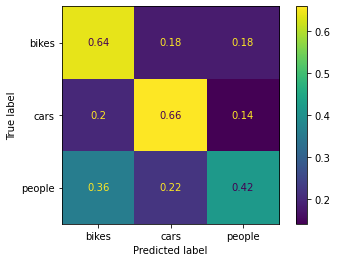

In [381]:
y_pred = cross_val_predict(SVMClassifier_hp(C=0.1,kernel='hist_int',gamma=0.001,poly_degree=3,features='allpixels'), X_raw, y)
conf_mat = confusion_matrix(y, y_pred,normalize='true')
cmd = ConfusionMatrixDisplay(conf_mat,display_labels=['bikes','cars','people'])
cmd.plot()

In [329]:
gs_svc_im = pd.concat([gs_SVC_all_results,gs_SVC_results])

In [360]:
gs_svc_im[(gs_svc_im.param_kernel=='log')&(gs_svc_im.param_features=='HoG')] 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_features,param_kernel,param_gamma,param_poly_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
170,7.641800,0.370531,0.998880,0.012826,0.01,HoG,log,NaN,2,"{'C': 0.01, 'features': 'HoG', 'kernel': 'log'...",0.500000,0.566667,0.533333,0.366667,0.366667,0.466667,0.084327,30
171,8.109949,0.082608,1.001487,0.026256,0.01,HoG,log,NaN,3,"{'C': 0.01, 'features': 'HoG', 'kernel': 'log'...",0.500000,0.566667,0.533333,0.366667,0.366667,0.466667,0.084327,30
178,7.765885,0.032460,0.960396,0.010817,0.1,HoG,log,NaN,2,"{'C': 0.1, 'features': 'HoG', 'kernel': 'log',...",0.466667,0.533333,0.500000,0.433333,0.366667,0.460000,0.057349,33
179,7.855130,0.056337,0.952597,0.037260,0.1,HoG,log,NaN,3,"{'C': 0.1, 'features': 'HoG', 'kernel': 'log',...",0.533333,0.600000,0.533333,0.433333,0.300000,0.480000,0.104563,29
186,8.023621,0.113935,1.006225,0.021527,1,HoG,log,NaN,2,"{'C': 1, 'features': 'HoG', 'kernel': 'log', '...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34
187,8.087699,0.166690,0.982162,0.023711,1,HoG,log,NaN,3,"{'C': 1, 'features': 'HoG', 'kernel': 'log', '...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34
194,7.697281,0.067403,0.948872,0.010140,10,HoG,log,NaN,2,"{'C': 10, 'features': 'HoG', 'kernel': 'log', ...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34
195,7.818902,0.071312,0.934754,0.014428,10,HoG,log,NaN,3,"{'C': 10, 'features': 'HoG', 'kernel': 'log', ...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34
202,7.994613,0.039451,0.977469,0.011051,100,HoG,log,NaN,2,"{'C': 100, 'features': 'HoG', 'kernel': 'log',...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34
203,7.994328,0.112822,0.963387,0.017036,100,HoG,log,NaN,3,"{'C': 100, 'features': 'HoG', 'kernel': 'log',...",0.533333,0.600000,0.500000,0.366667,0.266667,0.453333,0.120370,34


<ipython-input-336-9befbbbd3d6e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


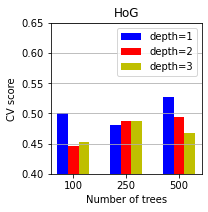

In [336]:

X = np.arange(3)
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, hog_1.mean_test_score, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, hog_2.mean_test_score, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, hog_3.mean_test_score, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0.4,0.65])
ax.legend()
ax.set_xticklabels([0,100,250,500])
ax.set_title('HoG')
ax.set_xlabel('Number of trees')
ax.grid(axis='y')
ax.set_ylabel('CV score')
plt.savefig('Figures\\Graphs\\hogboosting.png')
plt.show()
#ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

In [346]:
linhog = gs_svc_im[(gs_svc_im.param_kernel=='linear')&(gs_svc_im.param_features=='HoG')].mean_test_score
linmean = gs_svc_im[(gs_svc_im.param_kernel=='linear')&(gs_svc_im.param_features=='meanpixel')].mean_test_score
histall = gs_svc_im[(gs_svc_im.param_kernel=='hist_int')&(gs_svc_im.param_features=='allpixels')].mean_test_score
linmean = gs_svc_im[(gs_svc_im.param_kernel=='linear')&(gs_svc_im.param_features=='meanpixel')].mean_test_score

In [340]:
linhog

0     0.426667
4     0.446667
8     0.446667
12    0.446667
16    0.446667
Name: mean_test_score, dtype: float64

<ipython-input-357-ec9844617ed5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,0.01,0.1,1,10,100])


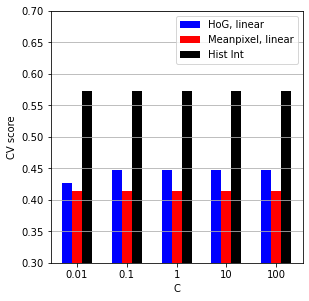

In [357]:
X = np.arange(5)
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, linhog, color = 'b', width = 0.2,label='HoG, linear')
ax.bar(X, linmean, color = 'r', width = 0.2,label='Meanpixel, linear')
ax.bar(X+0.2, histall, color = 'k', width = 0.2,label='Hist Int')
#ax.bar(X+0.2, hog_3.mean_test_score, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0.3,0.7])
ax.legend()
ax.set_xticklabels([0,0.01,0.1,1,10,100])
#ax.set_title()
ax.set_xlabel('C')
ax.grid(axis='y')
ax.set_ylabel('CV score')
#plt.savefig('Figures\\Graphs\\hogboosting.png')
plt.show()

In [361]:
gs_svc_im.to_excel('test.xlsx')

# Boosting

In [52]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
params = {'num_trees':[100,250,500],'tree_depth':[1,2,3], 'features':['HoG','meanpixel']}
#params = {'num_trees':[10],'tree_depth':[1], 'features':['HoG','meanpixel']}
gs_Boosting = GridSearchCV(BoostingClassifier(),param_grid=params,n_jobs=-1,verbose=3)
gs_Boosting.fit(X_raw,y)
gs_Boosting_results = pd.DataFrame(gs_Boosting.cv_results_)
%store gs_Boosting_results

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 112.1min finished


Stored 'gs_Boosting_results' (DataFrame)


In [59]:
gs_Boosting_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features,param_num_trees,param_tree_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,751.917384,90.087863,0.791653,0.169874,meanpixel,500,3,"{'features': 'meanpixel', 'num_trees': 500, 't...",0.466667,0.666667,0.666667,0.733333,0.400000,0.586667,0.129271,1
14,464.242781,0.952739,0.732568,0.004741,meanpixel,250,3,"{'features': 'meanpixel', 'num_trees': 250, 't...",0.433333,0.666667,0.666667,0.733333,0.366667,0.573333,0.145144,2
11,187.058153,0.491278,0.306322,0.003063,meanpixel,100,3,"{'features': 'meanpixel', 'num_trees': 100, 't...",0.433333,0.666667,0.600000,0.733333,0.400000,0.566667,0.129957,3
16,639.509311,4.804375,1.376201,0.134433,meanpixel,500,2,"{'features': 'meanpixel', 'num_trees': 500, 't...",0.466667,0.600000,0.666667,0.700000,0.400000,0.566667,0.115470,3
10,129.722536,0.292322,0.306968,0.004947,meanpixel,100,2,"{'features': 'meanpixel', 'num_trees': 100, 't...",0.466667,0.600000,0.666667,0.666667,0.366667,0.553333,0.118509,5
13,322.521639,0.447710,0.750821,0.042852,meanpixel,250,2,"{'features': 'meanpixel', 'num_trees': 250, 't...",0.433333,0.600000,0.566667,0.700000,0.366667,0.533333,0.119257,6
6,759.321641,0.933053,2.910535,0.070159,HoG,500,1,"{'features': 'HoG', 'num_trees': 500, 'tree_de...",0.666667,0.500000,0.466667,0.466667,0.533333,0.526667,0.074237,7
0,153.409769,0.836495,0.600849,0.004588,HoG,100,1,"{'features': 'HoG', 'num_trees': 100, 'tree_de...",0.500000,0.600000,0.500000,0.433333,0.466667,0.500000,0.055777,8
7,1423.686560,1.396248,2.852456,0.043931,HoG,500,2,"{'features': 'HoG', 'num_trees': 500, 'tree_de...",0.566667,0.533333,0.566667,0.366667,0.433333,0.493333,0.080000,9
9,69.303898,0.378712,0.310521,0.021754,meanpixel,100,1,"{'features': 'meanpixel', 'num_trees': 100, 't...",0.366667,0.500000,0.566667,0.633333,0.400000,0.493333,0.099778,10


In [79]:
params = {'num_trees':[100,250,500],'tree_depth':[1,2,3], 'features':['allpixels']}
gs_Boosting_all = GridSearchCV(BoostingClassifier(),param_grid=params,n_jobs=-1,verbose=3)
gs_Boosting_all.fit(X_raw,y)
gs_Boosting_results_all = pd.DataFrame(gs_Boosting_all.cv_results_)
%store gs_Boosting_results_all

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 116.3min finished


Stored 'gs_Boosting_results_all' (DataFrame)


In [80]:
gs_Boosting_results_all

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features,param_num_trees,param_tree_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,208.725218,7.246233,0.978163,0.090618,allpixels,100,1,"{'features': 'allpixels', 'num_trees': 100, 't...",0.366667,0.500000,0.600000,0.700000,0.300000,0.493333,0.146667,7
1,419.862735,4.726585,0.997504,0.065810,allpixels,100,2,"{'features': 'allpixels', 'num_trees': 100, 't...",0.466667,0.466667,0.533333,0.666667,0.366667,0.500000,0.098883,6
2,618.755615,3.036960,0.957199,0.047276,allpixels,100,3,"{'features': 'allpixels', 'num_trees': 100, 't...",0.433333,0.500000,0.666667,0.633333,0.433333,0.533333,0.098883,4
3,556.851770,3.984668,2.434703,0.045794,allpixels,250,1,"{'features': 'allpixels', 'num_trees': 250, 't...",0.466667,0.533333,0.566667,0.533333,0.300000,0.480000,0.095685,9
4,1039.267293,3.067451,2.385786,0.064458,allpixels,250,2,"{'features': 'allpixels', 'num_trees': 250, 't...",0.466667,0.533333,0.600000,0.666667,0.400000,0.533333,0.094281,5
5,1532.577524,5.965224,2.308104,0.171080,allpixels,250,3,"{'features': 'allpixels', 'num_trees': 250, 't...",0.533333,0.633333,0.600000,0.700000,0.433333,0.580000,0.090921,1
6,1081.478274,26.781765,4.377026,0.230923,allpixels,500,1,"{'features': 'allpixels', 'num_trees': 500, 't...",0.400000,0.566667,0.566667,0.600000,0.300000,0.486667,0.116619,8
7,1917.906550,17.406166,4.209773,0.310576,allpixels,500,2,"{'features': 'allpixels', 'num_trees': 500, 't...",0.533333,0.600000,0.600000,0.733333,0.433333,0.580000,0.097980,1
8,2270.610256,285.122410,2.769425,0.723418,allpixels,500,3,"{'features': 'allpixels', 'num_trees': 500, 't...",0.466667,0.666667,0.666667,0.633333,0.433333,0.573333,0.101980,3


In [130]:
boosting_hps = pd.concat([gs_Boosting_results_all,gs_Boosting_results])

In [131]:
boosting_hps

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features,param_num_trees,param_tree_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,208.725218,7.246233,0.978163,0.090618,allpixels,100,1,"{'features': 'allpixels', 'num_trees': 100, 't...",0.366667,0.500000,0.600000,0.700000,0.300000,0.493333,0.146667,7
1,419.862735,4.726585,0.997504,0.065810,allpixels,100,2,"{'features': 'allpixels', 'num_trees': 100, 't...",0.466667,0.466667,0.533333,0.666667,0.366667,0.500000,0.098883,6
2,618.755615,3.036960,0.957199,0.047276,allpixels,100,3,"{'features': 'allpixels', 'num_trees': 100, 't...",0.433333,0.500000,0.666667,0.633333,0.433333,0.533333,0.098883,4
3,556.851770,3.984668,2.434703,0.045794,allpixels,250,1,"{'features': 'allpixels', 'num_trees': 250, 't...",0.466667,0.533333,0.566667,0.533333,0.300000,0.480000,0.095685,9
4,1039.267293,3.067451,2.385786,0.064458,allpixels,250,2,"{'features': 'allpixels', 'num_trees': 250, 't...",0.466667,0.533333,0.600000,0.666667,0.400000,0.533333,0.094281,5
5,1532.577524,5.965224,2.308104,0.171080,allpixels,250,3,"{'features': 'allpixels', 'num_trees': 250, 't...",0.533333,0.633333,0.600000,0.700000,0.433333,0.580000,0.090921,1
6,1081.478274,26.781765,4.377026,0.230923,allpixels,500,1,"{'features': 'allpixels', 'num_trees': 500, 't...",0.400000,0.566667,0.566667,0.600000,0.300000,0.486667,0.116619,8
7,1917.906550,17.406166,4.209773,0.310576,allpixels,500,2,"{'features': 'allpixels', 'num_trees': 500, 't...",0.533333,0.600000,0.600000,0.733333,0.433333,0.580000,0.097980,1
8,2270.610256,285.122410,2.769425,0.723418,allpixels,500,3,"{'features': 'allpixels', 'num_trees': 500, 't...",0.466667,0.666667,0.666667,0.633333,0.433333,0.573333,0.101980,3
0,153.409769,0.836495,0.600849,0.004588,HoG,100,1,"{'features': 'HoG', 'num_trees': 100, 'tree_de...",0.500000,0.600000,0.500000,0.433333,0.466667,0.500000,0.055777,8


In [243]:
import matplotlib.pyplot as plt
%matplotlib inline

In [254]:

#hog
hog_1 = boosting_hps[(boosting_hps['param_tree_depth']==1)&(boosting_hps['param_features']=='HoG')][['mean_test_score','param_num_trees','mean_fit_time']]
hog_2 = boosting_hps[(boosting_hps['param_tree_depth']==2)&(boosting_hps['param_features']=='HoG')][['mean_test_score','param_num_trees','mean_fit_time']]
hog_3 = boosting_hps[(boosting_hps['param_tree_depth']==3)&(boosting_hps['param_features']=='HoG')][['mean_test_score','param_num_trees','mean_fit_time']]
#mean
mean_1 = boosting_hps[(boosting_hps['param_tree_depth']==1)&(boosting_hps['param_features']=='meanpixel')][['mean_test_score','param_num_trees','mean_fit_time']]
mean_2 = boosting_hps[(boosting_hps['param_tree_depth']==2)&(boosting_hps['param_features']=='meanpixel')][['mean_test_score','param_num_trees','mean_fit_time']]
mean_3 = boosting_hps[(boosting_hps['param_tree_depth']==3)&(boosting_hps['param_features']=='meanpixel')][['mean_test_score','param_num_trees','mean_fit_time']]
#all
all_1 = boosting_hps[(boosting_hps['param_tree_depth']==1)&(boosting_hps['param_features']=='allpixels')][['mean_test_score','param_num_trees','mean_fit_time']]
all_2 = boosting_hps[(boosting_hps['param_tree_depth']==2)&(boosting_hps['param_features']=='allpixels')][['mean_test_score','param_num_trees','mean_fit_time']]
all_3 = boosting_hps[(boosting_hps['param_tree_depth']==3)&(boosting_hps['param_features']=='allpixels')][['mean_test_score','param_num_trees','mean_fit_time']]

([<matplotlib.axis.XTick at 0x222966b3f40>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

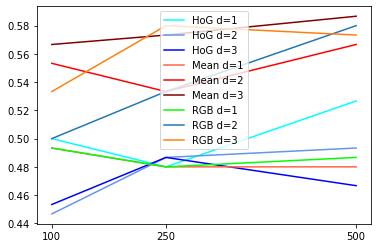

In [170]:
plt.plot(hog_1.param_num_trees,hog_1.mean_test_score,label='HoG d=1',c='aqua')
plt.plot(hog_2.param_num_trees,hog_2.mean_test_score,label='HoG d=2',c='cornflowerblue')
plt.plot(hog_3.param_num_trees,hog_3.mean_test_score,label='HoG d=3',c='blue')
plt.plot(mean_1.param_num_trees,mean_1.mean_test_score,label='Mean d=1',c='tomato')
plt.plot(mean_2.param_num_trees,mean_2.mean_test_score,label='Mean d=2',c='red')
plt.plot(mean_3.param_num_trees,mean_3.mean_test_score,label='Mean d=3',c='maroon')
plt.plot(mean_1.param_num_trees,all_1.mean_test_score,label='RGB d=1',c='lime')
plt.plot(mean_2.param_num_trees,all_2.mean_test_score,label='RGB d=2')
plt.plot(mean_3.param_num_trees,all_3.mean_test_score,label='RGB d=3')
plt.legend()
plt.xticks([100,250,500])

<ipython-input-252-b7809f045ab8>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


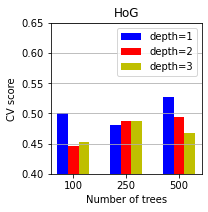

In [252]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(3)
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, hog_1.mean_test_score, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, hog_2.mean_test_score, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, hog_3.mean_test_score, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0.4,0.65])
ax.legend()
ax.set_xticklabels([0,100,250,500])
ax.set_title('HoG')
ax.set_xlabel('Number of trees')
ax.grid(axis='y')
ax.set_ylabel('CV score')
plt.savefig('Figures\\Graphs\\hogboosting.png')
plt.show()
#ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

<ipython-input-245-700d105b898c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])
<ipython-input-245-700d105b898c>:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


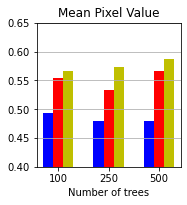

In [245]:
X = np.arange(3)
fig,ax = plt.subplots(1,1,figsize=[2,2])
ax = fig.add_axes([0,0,1,1])
ax.bar(X-0.2, mean_1.mean_test_score, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, mean_2.mean_test_score, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, mean_3.mean_test_score, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0.4,0.65])
ax.set_xticklabels([0,100,250,500])
ax.set_title('Mean Pixel Value')
ax.set_xlabel('Number of trees')
ax.grid(axis='y')
plt.tight_layout()
plt.savefig('Figures\\Graphs\\meanboosting.png')

plt.show()

<ipython-input-246-82ab7b218e34>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


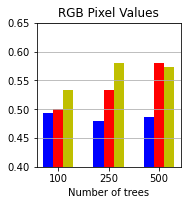

In [246]:
X = np.arange(3)
fig = plt.figure(figsize=[2,2])
ax = fig.add_axes([0,0,1,1])
ax.bar(X-0.2, all_1.mean_test_score, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, all_2.mean_test_score, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, all_3.mean_test_score, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0.4,0.65])
ax.set_xticklabels([0,100,250,500])
ax.set_title('RGB Pixel Values')
ax.set_xlabel('Number of trees')
ax.grid(axis='y')
plt.savefig('Figures\\Graphs\\allboosting.png')
plt.show()

<ipython-input-264-57d6eac5b3c0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


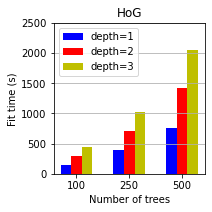

In [264]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(3)
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, hog_1.mean_fit_time, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, hog_2.mean_fit_time, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, hog_3.mean_fit_time, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0,2500])
ax.legend()
ax.set_xticklabels([0,100,250,500])
ax.set_title('HoG')
ax.set_xlabel('Number of trees')
ax.grid(axis='y')
ax.set_ylabel('Fit time (s)')
plt.savefig('Figures\\Graphs\\hogboosting.png')
plt.show()
#ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

<ipython-input-268-ddbd8e9d7cc9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


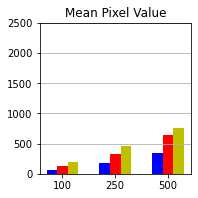

In [268]:
X = np.arange(3)
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, mean_1.mean_fit_time, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, mean_2.mean_fit_time, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, mean_3.mean_fit_time, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0,2500])
ax.set_xticklabels([0,100,250,500])
ax.set_title('Mean Pixel Value')
ax.grid(axis='y')
plt.show()

<ipython-input-270-70c6b2ba262b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,100,250,500])


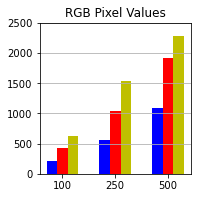

In [270]:
X = np.arange(3)
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.bar(X-0.2, all_1.mean_fit_time, color = 'b', width = 0.2,label='depth=1')
ax.bar(X, all_2.mean_fit_time, color = 'r', width = 0.2,label='depth=2')
ax.bar(X+0.2, all_3.mean_fit_time, color = 'y', width = 0.2,label='depth=3')
ax.set_ylim([0,2500])
ax.set_xticklabels([0,100,250,500])
ax.set_title('RGB Pixel Values')
ax.grid(axis='y')
plt.show()

In [154]:
boosting_hps.sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features,param_num_trees,param_tree_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,751.917384,90.087863,0.791653,0.169874,meanpixel,500,3,"{'features': 'meanpixel', 'num_trees': 500, 't...",0.466667,0.666667,0.666667,0.733333,0.400000,0.586667,0.129271,1
5,1532.577524,5.965224,2.308104,0.171080,allpixels,250,3,"{'features': 'allpixels', 'num_trees': 250, 't...",0.533333,0.633333,0.600000,0.700000,0.433333,0.580000,0.090921,1
7,1917.906550,17.406166,4.209773,0.310576,allpixels,500,2,"{'features': 'allpixels', 'num_trees': 500, 't...",0.533333,0.600000,0.600000,0.733333,0.433333,0.580000,0.097980,1
14,464.242781,0.952739,0.732568,0.004741,meanpixel,250,3,"{'features': 'meanpixel', 'num_trees': 250, 't...",0.433333,0.666667,0.666667,0.733333,0.366667,0.573333,0.145144,2
8,2270.610256,285.122410,2.769425,0.723418,allpixels,500,3,"{'features': 'allpixels', 'num_trees': 500, 't...",0.466667,0.666667,0.666667,0.633333,0.433333,0.573333,0.101980,3
16,639.509311,4.804375,1.376201,0.134433,meanpixel,500,2,"{'features': 'meanpixel', 'num_trees': 500, 't...",0.466667,0.600000,0.666667,0.700000,0.400000,0.566667,0.115470,3
11,187.058153,0.491278,0.306322,0.003063,meanpixel,100,3,"{'features': 'meanpixel', 'num_trees': 100, 't...",0.433333,0.666667,0.600000,0.733333,0.400000,0.566667,0.129957,3
10,129.722536,0.292322,0.306968,0.004947,meanpixel,100,2,"{'features': 'meanpixel', 'num_trees': 100, 't...",0.466667,0.600000,0.666667,0.666667,0.366667,0.553333,0.118509,5
2,618.755615,3.036960,0.957199,0.047276,allpixels,100,3,"{'features': 'allpixels', 'num_trees': 100, 't...",0.433333,0.500000,0.666667,0.633333,0.433333,0.533333,0.098883,4
4,1039.267293,3.067451,2.385786,0.064458,allpixels,250,2,"{'features': 'allpixels', 'num_trees': 250, 't...",0.466667,0.533333,0.600000,0.666667,0.400000,0.533333,0.094281,5


In [307]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(BoostingClassifier(num_trees=500,tree_depth=3,features='meanpixel',flip=True), X_raw, y)
conf_mat = confusion_matrix(y, y_pred,normalize='true')

In [300]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

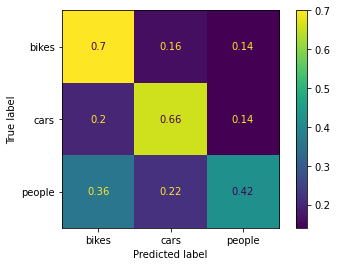

In [324]:
y_pred = cross_val_predict(BoostingClassifier(num_trees=500,tree_depth=3,features='meanpixel',flip=True), X_raw, y)
conf_mat = confusion_matrix(y, y_pred,normalize='true')
cmd = ConfusionMatrixDisplay(conf_mat,display_labels=['bikes','cars','people'])
cmd.plot()